# Inference Homework 5
## Alex Pine
## 2015/11/21

## Question 1 

I collaborated with Israel Malkin on this problem.

Let the directed tree $T$ represent a Bayesian network corresponding to the probability distribution $p_T(\textbf{x})$. By definition, $p_T$ takes the form

$$ p_T(\textbf{x}) = \prod_{x_i \in \textbf{x}}p(x_i \mid \text{pa}(x)) $$

All nodes have at most one parent node in a tree, so we can denote $\text{pa}(x) = x_p$.

$$ p_T(\textbf{x}) = \prod_{x_i \in \textbf{x}}p(x_i \mid x_p) $$

Applying Bayes' rule, this becomes

$$ p_T(\textbf{x}) = \prod_{x_i \in \textbf{x}}\frac{p(x_i, x_p)}{p(x_p)} $$

Multiplying this by $\prod_{x_i \in \textbf{x}}\frac{p(x_i)}{p(x_i)} = 1$, this becomes

$$ p_T(\textbf{x}) = \prod_{x_i \in \textbf{x}}\frac{p(x_i, x_p)}{p(x_i)p(x_p)} \prod_{x_i \in \textbf{x}}p(x_i)$$

Since the set of edges $T$ are between parents and children, and each node is a child of one or zero parents, each $i$ appears once in the edges $(i,j) \in T$. This means we can change the indices of the first product to be the set of edges in $T$ without changing the value of the expression. If we also denote $V$ to be the set containing the marginal variables of $\textbf{x}$, then this formula can be rewritten as 

$$ p_T(\textbf{x}) = \prod_{(i,j) \in T}\frac{p(x_i, x_j)}{p(x_i)p(x_j)} \prod_{x_i \in V}p(x_i)$$

This probability distribution corresponds to an MRF with the same nodes and edges as $T$, where each node $x_i$ has the potential $p(x_i)$, and each edge has the potential $p(x_i, x_j)$, which is what we were trying to prove.

# Question 2

I collaborated with Maya Rotmensch on this problem.

In [3]:
import numpy as np

def read_chowlui_input():
    input_matrix = []
    with open('inference/hw5/data/chowliu-input.txt', 'r') as f:
        for line in f:
            input_matrix.append([int(token) for token in line.split()])
    return np.array(input_matrix)        

def read_labels_input():
    input_labels = []
    with open('inference/hw5/data/names.txt', 'r') as f:
        for line in f:
            input_labels.append(line.strip())
    return np.array(input_labels)

input_matrix = read_chowlui_input()
labels = read_labels_input()

In [4]:
import scipy.sparse.csgraph

# Given the input matrix, which has one row for each data point, and a column for each item,
# create two matrices: 
# 1) both_count_matrix: 
#    When i > j: A[i][j] = the number of times items i and j were both present. 
#    When i == j: A[i][j] = the number of times item i appears in the data set.
#    When i < j: A[i][j] = zero. This portion is not used.
# 2) single_count_matrix: 
#    When i != j: B[i][j] = the number of times item i was present and j was not.
#    When i == j: B[i][j] = zero. This portion is not used.
def create_count_matrices(input_matrix): 
    both_count_matrix = np.zeros((input_matrix.shape[1], input_matrix.shape[1]), dtype=int)
    single_count_matrix = np.zeros((input_matrix.shape[1], input_matrix.shape[1]), dtype=int)
    for row in input_matrix:
        for i in range(len(row)):
            for j in range(len(row)):
                if i > j and row[i] == 1 and row[j] == 1:
                    both_count_matrix[i][j] += 1
                if row[i] == 1 and row[j] == 0: 
                    single_count_matrix[i][j] += 1
            if row[i] == 1:
                both_count_matrix[i][i] += 1
    return both_count_matrix, single_count_matrix

both_count_matrix, single_count_matrix = create_count_matrices(input_matrix)

In [2]:
# Functions needed to create a matrix that has the mutual information between each item,
# based on their empirical probabilities.
# I actually take the inverse of the mutual information, so that a minimum spanning tree
# algorithm can be used to find the maximum spanning tree.

import itertools
import numpy.ma as ma    
    
# Computes one part of the sum of the "empirical" mutual information between x_i and x_j.
def mutual_info_part(num_xixj, num_xi, num_xj, total):
    if not num_xixj or not num_xi or not num_xj:
        return 0.0
    p_xixj = 1.0 * num_xixj / total
    p_xi = 1.0 * num_xi / total
    p_xj = 1.0 * num_xj / total
    return p_xixj * math.log(p_xixj / (p_xi * p_xj), 2)


def mutual_info(i, j, num_data, both_count_matrix, single_count_matrix):
    num_xi_one = both_count_matrix[i][i]  
    num_xj_one = both_count_matrix[j][j]
    num_xi_zero = num_data - num_xi_one
    num_xj_zero = num_data - num_xj_one    
    info = 0.0
    # 11 case
    info += mutual_info_part(both_count_matrix[i][j], num_xi_one, num_xj_one, num_data)
    # 10 case
    info += mutual_info_part(single_count_matrix[i][j], num_xi_one, num_xj_zero, num_data)
    # 01 case
    info += mutual_info_part(single_count_matrix[j][i], num_xi_zero, num_xj_one, num_data)
    # 00 case
    neither_count = (num_data - both_count_matrix[i][j] - single_count_matrix[i][j] 
                     - single_count_matrix[j][i])
    info += mutual_info_part(neither_count, num_xi_zero, num_xj_zero, num_data)
    assert (neither_count + both_count_matrix[i][j] + single_count_matrix[i][j] 
            + single_count_matrix[j][i] == num_data)
    return info
    
# Create a matrix where each value is the inverse of the mutual information values 
# between each item.
def create_inv_mutual_info_matrix(num_data, both_count_matrix, single_count_matrix):
    inv_info_matrix = np.zeros(both_count_matrix.shape)
    # Create a mask for the upper right corner, to mark this matrix as triangular.
    info_mask = np.zeros(both_count_matrix.shape, dtype=int)
    num_items = both_count_matrix.shape[1]
    for i in range(num_items):
        for j in range(i):
            info = mutual_info(i, j, num_data, both_count_matrix, single_count_matrix)
            inv_info_matrix[i][j] = 1.0 / info
        for j in range(i, num_items):
            info_mask[i][j] = 1
    inv_info_matrix = ma.array(inv_info_matrix, mask=info_mask)
    return inv_info_matrix


num_data = input_matrix.shape[0]
inv_info_matrix = create_inv_mutual_info_matrix(
    num_data, both_count_matrix, single_count_matrix)

NameError: name 'input_matrix' is not defined

In [681]:
import scipy.sparse.csgraph

mst_rows, mst_columns = scipy.sparse.csgraph.minimum_spanning_tree(inv_info_matrix).nonzero()
mst_edge_pairs = zip(mst_rows, mst_columns)

In [682]:
# Code for calculating the potential functions on nodes and edges, now that we have the 
# structure of the tree.

def edge_part(num_xixj, num_xi, num_xj, total):   
    p_xixj = 1.0 * num_xixj / total
    p_xi = 1.0 * num_xi / total
    p_xj = 1.0 * num_xj / total
    return p_xixj / (p_xi * p_xj)


def edge_potential(i, j, num_data, both_count_matrix, single_count_matrix):
    num_xi_one = both_count_matrix[i][i]  
    num_xj_one = both_count_matrix[j][j]
    num_xi_zero = num_data - num_xi_one
    num_xj_zero = num_data - num_xj_one
    potential = np.zeros((2, 2))
    # 11 case
    potential[1][1] = edge_part(both_count_matrix[i][j], num_xi_one, num_xj_one, num_data)
    # 10 case
    potential[1][0] = edge_part(single_count_matrix[i][j], num_xi_one, num_xj_zero, num_data)
    # 01 case
    potential[0][1] = edge_part(single_count_matrix[j][i], num_xi_zero, num_xj_one, num_data)
    # 00 case
    neither_count = (num_data - both_count_matrix[i][j] - single_count_matrix[i][j] 
                     - single_count_matrix[j][i])
    potential[0][0] = edge_part(neither_count, num_xi_zero, num_xj_zero, num_data)
    assert (neither_count + both_count_matrix[i][j] + single_count_matrix[i][j] 
            + single_count_matrix[j][i] == num_data)
    return potential


def node_potential(i, num_data, both_count_matrix):
    num_xi_one = both_count_matrix[i][i]
    num_xi_zero = num_data - num_xi_one
    return np.array([float(num_xi_one) / num_data, float(num_xi_zero) / num_data]) 


def create_graph_potentials(mst_edge_pairs, num_data, 
                            both_count_matrix, single_count_matrix):
    # Every node i has a 1x2 potential matrix
    node_potentials = np.ndarray((both_count_matrix.shape[0], 2))
    # Every edge (i,j) has a 2x2 potential matrix.
    edge_potentials = np.ndarray((both_count_matrix.shape[0], both_count_matrix.shape[1], 
                                  2, 2))
    num_items = both_count_matrix.shape[1]
    for i in range(num_items):
        for j in range(i):
            edge_potentials[i][j] = edge_potential(i, j, num_data, both_count_matrix, 
                                                   single_count_matrix)
        node_potentials[i] = node_potential(i, num_data, both_count_matrix)
    return node_potentials, edge_potentials

node_potentials, edge_potentials = create_graph_potentials(
    mst_edge_pairs, num_data, both_count_matrix, single_count_matrix)

In [1]:
# Debugging

# for i, j in mst_edge_pairs:
#    print i, j, labels[i], '--', labels[j], ":", edge_potentials[i][j][1][1]

In [684]:
# Creates a string that reprsents the Markov random field in UAI format.
# http://www.hlt.utdallas.edu/~vgogate/uai14-competition/modelformat.html
def create_graph_as_uai_file(mst_edge_pairs, node_potentials, edge_potentials):
    num_vars = node_potentials.shape[0]    
    
    network_type = 'MARKOV'
    num_vars_str = str(num_vars)
    var_cardinals = ' '.join(['2']*num_vars)
    num_cliques = str(len(mst_edge_pairs) + num_vars)
    node_cliques = ['1 ' + str(i) for i in range(num_vars)]
    edge_cliques = [' '.join(['2', str(i), str(j)]) for i, j in mst_edge_pairs]
    preamble = ([network_type, num_vars_str, var_cardinals, num_cliques] + node_cliques 
                + edge_cliques)
    
    function_tables = []
    # node potentials
    for i in range(num_vars):
        prob_str = ' '.join([' ', str(node_potentials[i][0]), str(node_potentials[i][1])])
        function_tables += ['', '2', prob_str]
    # edge potentials
    for i, j in mst_edge_pairs:
        assert i > j
        prob00 = edge_potentials[i][j][0][0]
        prob01 = edge_potentials[i][j][0][1]
        prob_str1 = ' '.join([' ', str(prob00), str(prob01)])
        prob10 = edge_potentials[i][j][1][0]
        prob11 = edge_potentials[i][j][1][1]
        prob_str2 = ' '.join([' ', str(prob10), str(prob11)])
        function_tables += ['', '4', prob_str1, prob_str2]
    return '\n'.join(preamble + function_tables + [''])
        
uai_str = create_graph_as_uai_file(mst_edge_pairs, node_potentials, edge_potentials)

with open ('hw5_prob2.uai', 'w') as f:
    f.write(uai_str)

## Question 3
I collaborated with Israel Malkin and Peter Li on this problem.

Define kernel function $p(x_i, x_j) = C^{-1}_{i,j}$, where $C$ is a covariance matrix and $C_{i,j} = k(x_i, x_j)$, and $x_i, x_j \in \mathbf{x_n}$, a sequence of i.i.d random variables. 

Drawing the first variable, $x_1$, results in a covariance matrix $C_1 = \big{(}k(x_1, x_1)\big{)}$, which implies that $C^{-1}_{1} = \big{(}\frac{1}{k(x_1, x_1)}\big{)}$ which implies $p(x_1, x_1) = \frac{1}{k(x_1, x_1)}$.

Drawing a second variable, $x_2$, results in a covariance matrix 

$$ C_2 = \left( \begin{array}{cc}
k(x_1, x_1) & k(x_1, x_2) \\
k(x_1, x_2) & k(x_2, x_2) \end{array} \right) $$

Since $C_2$ is a covariance matrix, it must be symmetric, so $k(x_1, x_2) = k(x_2, x_1)$, and its inverse is given by

$$ C^{-1}_2 = \frac{1}{k(x_1, x_1)k(x_2, x_2) - k(x_1, x_2)^2} \left( \begin{array}{cc}
k(x_2, x_2) & -k(x_1, x_2) \\
-k(x_1, x_2) & k(x_1, x_1) \end{array} \right) $$

Since the first element of $C^{-1}_2 = p(x_1, x_1)$, this implies

$$ p(x_1, x_1) = \frac{k(x_2, x_2)}{k(x_1, x_1)k(x_2, x_2) - k(x_1, x_2)^2} $$

Plugging in $p(x_1, x_1) = \frac{1}{k(x_1, x_1)}$ from above, this turns into 

$$ \frac{1}{k(x_1, x_1)} = \frac{k(x_2, x_2)}{k(x_1, x_1)k(x_2, x_2) - k(x_1, x_2)^2} $$

Rearranging, this becomes,

$$ k(x_1, x_1)k(x_2, x_2) = k(x_1, x_1)k(x_2, x_2) - k(x_1, x_2)^2 $$

which implies

$$ k(x_1, x_2) = k(x_2, x_1) = 0 $$

This means that $p(x_i, x_j)$ only exists if $C$ is a diagonal matrix. Since $C$ is not required to be diagonal, this implies that $p(x_i, x_j)$ does not exist generally.

## Question 4
I collaborated with Peter Li on this problem.

I've graphed four covariance functions:

1) Exponential (not differentiable, not compact)

2) Squared Exponential (differentiable, not compact)

3) Spherical (not differentiable, compact)

4) Linear (differentiable, not compact)

In [435]:
# Covariance functions

import itertools
import math
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline  

# 1) Exponential (not differentiable, not compact)
def make_exp_covar_fn(tau, l):
    def exp_covar_fn(x, y):
        return tau**2 * math.exp(-np.linalg.norm(x - y) / (2*l))
    return exp_covar_fn

# 2) Squared Exponential (differentiable, not compact)
def make_squared_exp_covar_fn(tau, l):
    def squared_exp_covar_fn(x, y):
        diff = x - y
        return tau**2 * math.exp(-np.inner(diff, diff) / (2*(l**2)))
    return squared_exp_covar_fn

# 3) Spherical (not differentiable, compact)
def make_spherical_covar_fn(tau, theta):
    def spherical_covar_fn(x, y):
        dist = np.linalg.norm(x - y)
        if dist <= theta:
            return tau**2 * (1 - 3*dist/(2*theta) + dist**3/(2*theta**3))
        else:
            return 0.0
    return spherical_covar_fn

# 4) Linear (differentiable, not compact)
def make_linear_covar_fn(sigma, tau, c):
    def linear_covar_fn(x, y):
        return sigma**2 + tau**2 * np.inner(x - c, y - c)
    return linear_covar_fn


In [317]:
# This samples from a multivariate Gaussian distribution, with a zero mean 
# value, and a covariance matrix determined by the convariance function 
# and the x values parameters.
def sample_gp(xs, covar_fn):
    mean_vec = np.zeros(len(xs))
    gram_matrix = np.zeros((len(xs), len(xs)))
    for i in range(len(xs)):
        x_i = xs[i]
        for j in range(0, i):
            x_j = xs[j]
            gram_matrix[i][j] = covar_fn(x_i, x_j)
            gram_matrix[j][i] = gram_matrix[i][j]
        gram_matrix[i][i] = covar_fn(x_i, x_i)
    samples = np.random.multivariate_normal(mean_vec, gram_matrix)
    return samples
   

In [491]:
def plot_covar_fn(title, covar_fn_maker, param_list, param_names):
    covar_fn_list = [covar_fn_maker(*params) for params in param_list]
    ys = np.arange(0.0, 1.0, 0.01)
    
    covar_vals = []
    sample_vals = []
    for covar_fn in covar_fn_list:
        covar_vals.append([covar_fn(0.0, y) for y in ys])
        sample_vals.append(sample_gp(ys, covar_fn))
        
    fig = plt.figure(1, figsize=(18, 6))
    # Covariance values
    plt.subplot(1, 2, 1)
    plt.title(title + ': Covariance function values')
    plt.xlabel('y_i - x_i')
    plt.ylabel('covariance(x_i, y_i)')
    lines = []
    for params, covar_val in zip(param_list, covar_vals):
        param_str = ", ".join([name + ": " + str(param) 
                               for name, param in zip(param_names, params)])
        line, = plt.plot(ys, covar_val)
        lines.append(param_str)
    plt.legend(lines)
    # Gaussian Process samples
    plt.subplot(1, 2, 2)
    plt.title(title + ': GP Samples')
    for sample_val in sample_vals:
        plt.plot(ys, sample_val)
    plt.xlabel('y_i - x_i')
    plt.ylabel('Guassian Sample (x_i, y_i)')    
    plt.show()     

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


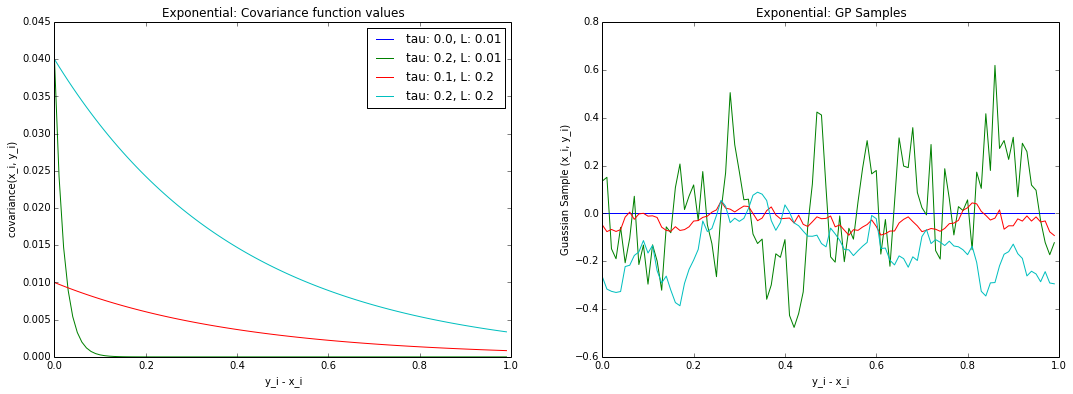

In [492]:
# L can't be zero or you get a divide by zero error
exp_params = [(0.0, 0.01), (0.2, 0.01), (0.1, 0.2), (0.2, 0.2)]
plot_covar_fn("Exponential", make_exp_covar_fn, exp_params, ['tau', 'L'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


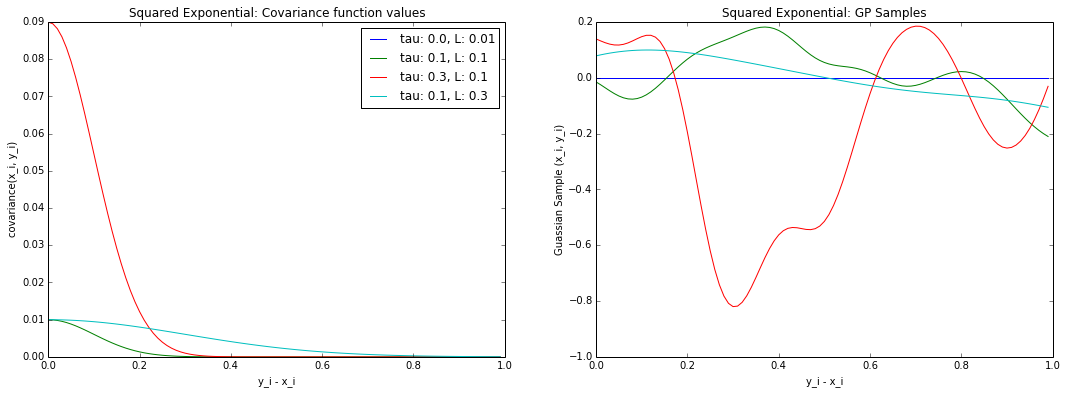

In [494]:
squared_exp_params = [(0.0, 0.01), (0.1, 0.1), (0.3, 0.1), (0.1, 0.3)]
plot_covar_fn("Squared Exponential", make_squared_exp_covar_fn, 
                  squared_exp_params, ['tau', 'L'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


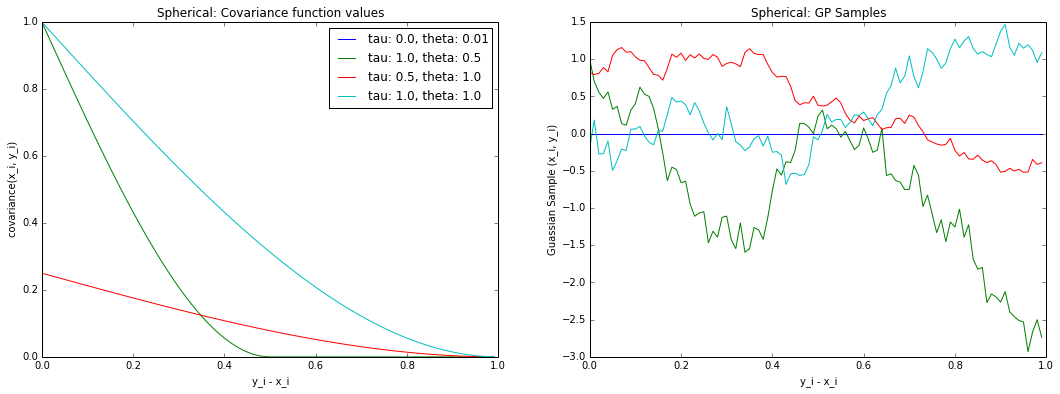

In [495]:
spherical_params = [(0.0, 0.01), (1.0, 0.5), (0.5, 1.0), (1.0, 1.0)]
plot_covar_fn("Spherical", make_spherical_covar_fn, 
              spherical_params, ['tau', 'theta'])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


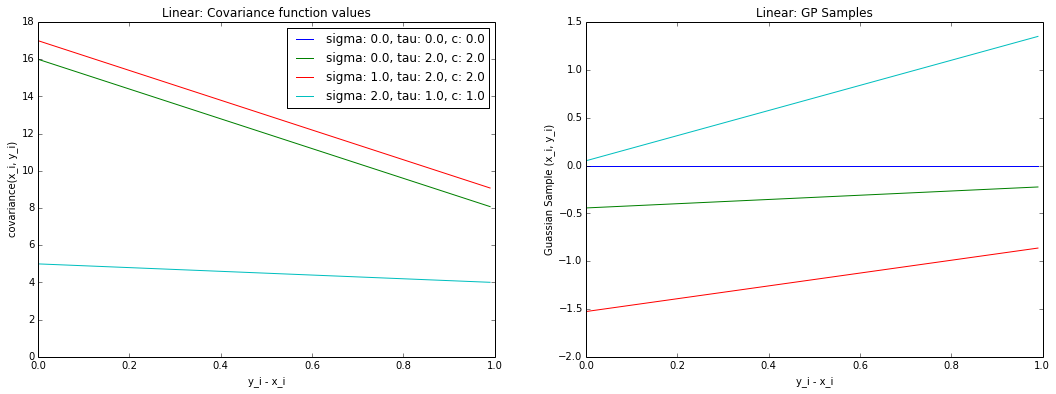

In [496]:
linear_param_list = [(0.0, 0.0, 0.0), (0.0, 2.0, 2.0), (1.0, 2.0, 2.0), (2.0, 1.0, 1.0)]
plot_covar_fn("Linear", make_linear_covar_fn, linear_param_list, ['sigma', 'tau', 'c'])